# ML Training with MSD Lung RadiObject: Segmentation

This notebook trains a 3D UNet for lung tumor segmentation using the Medical Segmentation Decathlon data.

## Overview

1. **Load** RadiObject from URI (S3 or local)
2. **Explore** data and segmentation masks
3. **Split** into train/validation sets
4. **Train** a MONAI UNet model
5. **Evaluate** with Dice score

## Task

Semantic segmentation: Predict lung tumor mask from CT volume patches.

**Prerequisites:** Run [05_ingest_msd.ipynb](./05_ingest_msd.ipynb) first to create the MSD Lung RadiObject with CT and seg collections.

In [1]:
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
from config import MSD_LUNG_URI, S3_REGION
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import Compose, RandFlipd

from radiobject import RadiObject, configure
from radiobject.ctx import S3Config
from radiobject.ml import (
    create_training_dataloader,
    create_validation_dataloader,
)

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"RadiObject URI: {MSD_LUNG_URI}")

PyTorch version: 2.10.0
NumPy version: 2.4.1
RadiObject URI: s3://souzy-scratch/msd-lung/radiobject-2mm


/Users/samueldsouza/Desktop/Code/RadiObject/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Determine compute device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print(f"Training device: {DEVICE}")

Training device: mps


In [3]:
# Configure S3 access if using S3 URI
if MSD_LUNG_URI.startswith("s3://"):
    configure(s3=S3Config(region=S3_REGION, max_parallel_ops=8))

TEMP_DIR = tempfile.mkdtemp(prefix="msd_ml_")
print(f"Temp directory: {TEMP_DIR}")

Temp directory: /var/folders/dj/0_0s64j55hn0gk7rrvj09zf80000gn/T/msd_ml_l6x_amwt


In [4]:
# Load RadiObject
radi = RadiObject(MSD_LUNG_URI)

# Quick summary using describe()
print(radi.describe())

RadiObject Summary
URI: s3://souzy-scratch/msd-lung/radiobject-2mm
Subjects: 63
Collections: 2

Collections:
  - seg: 63 volumes, shape=250x250x318
  - CT: 63 volumes, shape=250x250x318

Label Columns:
  - has_tumor: {1: 63}
  - original_shape_x: {512: 63}
  - original_shape_y: {512: 63}


In [5]:
# Verify both CT and seg collections exist
print(f"Collections: {radi.collection_names}")
print(f"CT shape: {radi.CT.shape}")
print(f"seg shape: {radi.seg.shape}")

if "seg" not in radi.collection_names:
    raise RuntimeError(
        "Segmentation collection not found. "
        "Please re-run 05_ingest_msd.ipynb with FORCE_REINGEST=True"
    )

Collections: ('seg', 'CT')
CT shape: (250, 250, 318)
seg shape: (250, 250, 318)


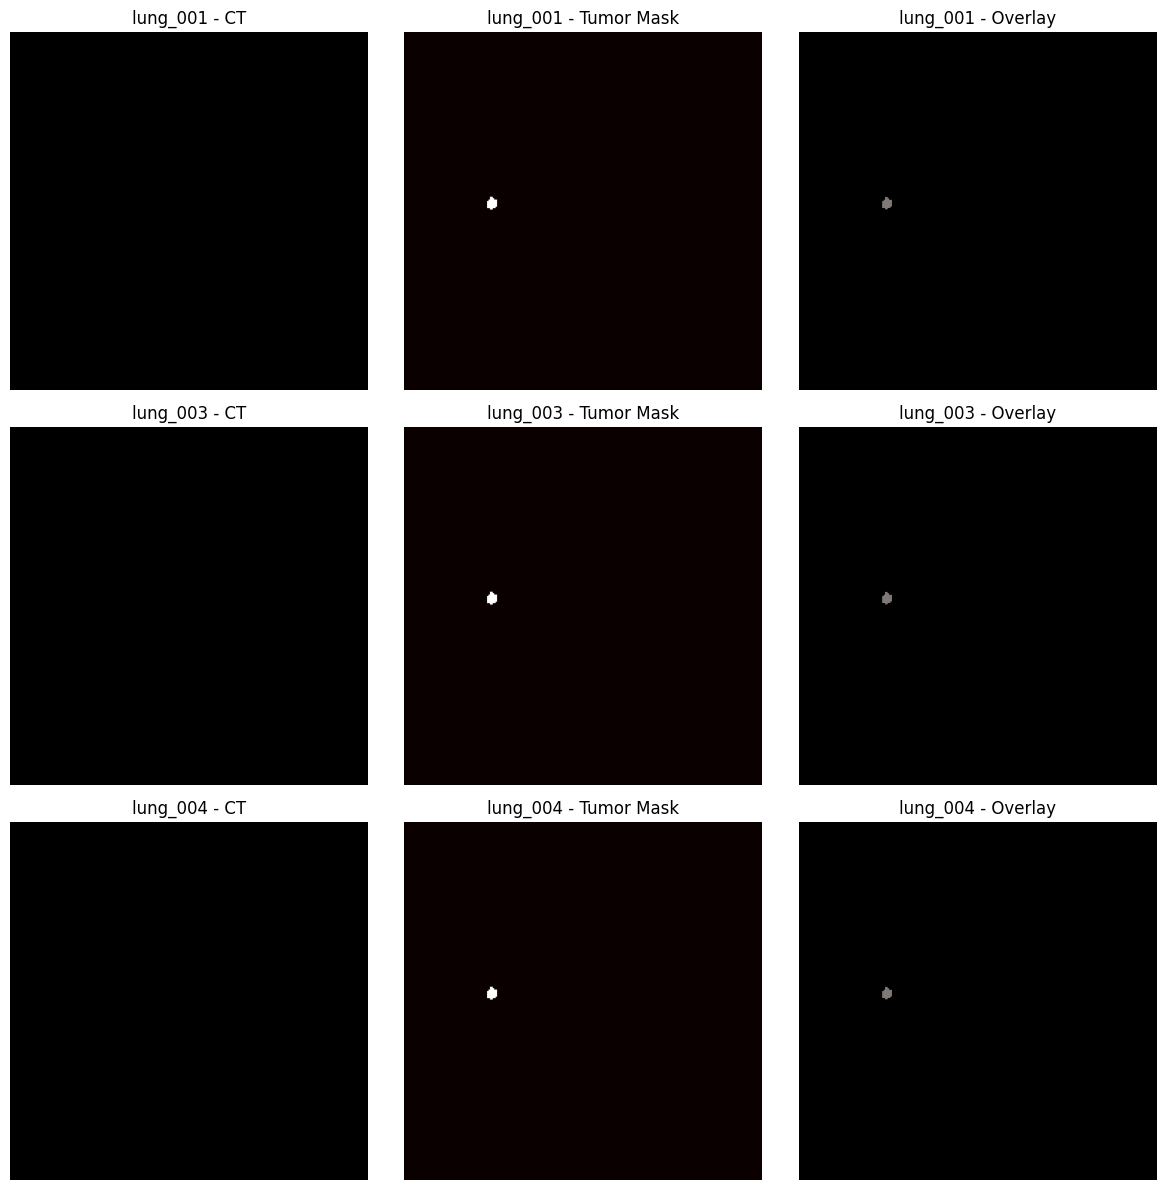

In [6]:
# Visualize CT and segmentation overlay for a few subjects
subject_ids = list(radi.obs_subject_ids)[:3]

fig, axes = plt.subplots(len(subject_ids), 3, figsize=(12, 4 * len(subject_ids)))

for row, subject_id in enumerate(subject_ids):
    ct_vol = radi.loc[subject_id].CT.iloc[0]
    seg_vol = radi.loc[subject_id].seg.iloc[0]

    # Find slice with tumor
    seg_data = seg_vol.to_numpy()
    tumor_slices = np.where(seg_data.sum(axis=(0, 1)) > 0)[0]
    mid_z = (
        tumor_slices[len(tumor_slices) // 2] if len(tumor_slices) > 0 else seg_data.shape[2] // 2
    )

    # CT
    axes[row, 0].imshow(ct_vol.axial(z=mid_z).T, cmap="gray", origin="lower")
    axes[row, 0].set_title(f"{subject_id} - CT")
    axes[row, 0].axis("off")

    # Segmentation
    axes[row, 1].imshow(seg_vol.axial(z=mid_z).T, cmap="hot", origin="lower")
    axes[row, 1].set_title(f"{subject_id} - Tumor Mask")
    axes[row, 1].axis("off")

    # Overlay
    axes[row, 2].imshow(ct_vol.axial(z=mid_z).T, cmap="gray", origin="lower")
    mask = seg_vol.axial(z=mid_z).T > 0
    axes[row, 2].imshow(np.ma.masked_where(~mask, mask), cmap="Reds", alpha=0.5, origin="lower")
    axes[row, 2].set_title(f"{subject_id} - Overlay")
    axes[row, 2].axis("off")

plt.tight_layout()
plt.show()

In [7]:
# 80/20 split
all_ids = list(radi.obs_subject_ids)
np.random.seed(42)
np.random.shuffle(all_ids)

split_idx = int(0.8 * len(all_ids))
train_ids = all_ids[:split_idx]
val_ids = all_ids[split_idx:]

print(f"Training subjects: {len(train_ids)}")
print(f"Validation subjects: {len(val_ids)}")

Training subjects: 50
Validation subjects: 13


In [8]:
# Create train/val RadiObjects using loc[] and to_radi_object()
train_uri = f"{TEMP_DIR}/train_radi"
val_uri = f"{TEMP_DIR}/val_radi"

radi_train = radi.loc[train_ids].to_radi_object(train_uri)
radi_val = radi.loc[val_ids].to_radi_object(val_uri)

print(f"Train RadiObject: {radi_train}")
print(f"Val RadiObject: {radi_val}")

Train RadiObject: RadiObject(50 subjects, 2 collections: [CT, seg])
Val RadiObject: RadiObject(13 subjects, 2 collections: [CT, seg])


In [9]:
# Training hyperparameters
BATCH_SIZE = 2
PATCH_SIZE = (64, 64, 64)

# Define transforms - only random flip (applies to both CT and seg consistently)
# Normalization is applied only to CT channel in training loop
train_transform = Compose(
    [
        RandFlipd(keys="image", prob=0.5, spatial_axis=[0, 1, 2]),
    ]
)

# Create dataloaders with multi-collection input
# [CT, seg] -> stacked as channels: batch["image"] shape (B, 2, D, H, W)
# Channel 0 = CT (input), Channel 1 = seg (label)
train_loader = create_training_dataloader(
    [radi_train.CT, radi_train.seg],  # Multi-collection: first=image, second=label
    batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False,
    transform=train_transform,
)

# Validation: no augmentation
val_loader = create_validation_dataloader(
    [radi_val.CT, radi_val.seg],
    batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE,
    num_workers=0,
    pin_memory=False,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 25
Val batches: 7


In [10]:
# Inspect a batch
batch = next(iter(train_loader))

print(f"Batch keys: {list(batch.keys())}")
print(f"Image shape: {batch['image'].shape}")  # (B, 2, D, H, W) - CT + seg stacked
print(f"Image dtype: {batch['image'].dtype}")
print(f"Memory per batch: {batch['image'].nbytes / 1024 / 1024:.1f} MB")

# Verify channel structure
ct_channel = batch["image"][:, 0:1, ...]  # CT
seg_channel = batch["image"][:, 1:2, ...]  # Segmentation mask
print(f"\nCT channel range: [{ct_channel.min():.2f}, {ct_channel.max():.2f}]")
print(f"Seg channel unique values: {torch.unique(seg_channel).tolist()}")

Batch keys: ['image', 'idx', 'patch_idx', 'patch_start']
Image shape: torch.Size([2, 2, 64, 64, 64])
Image dtype: torch.float32
Memory per batch: 4.0 MB

CT channel range: [-1269.10, 2039.46]
Seg channel unique values: [0.0, 1.0]


In [11]:
# MONAI UNet for 3D segmentation
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,  # background + tumor
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
).to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 1,186,765


In [12]:
# Training configuration
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = DiceCELoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Training history
history = {
    "train_loss": [],
    "train_dice": [],
    "val_loss": [],
    "val_dice": [],
}


def normalize_ct(x: torch.Tensor) -> torch.Tensor:
    """Normalize CT intensities to zero mean, unit variance."""
    return (x - x.mean()) / (x.std() + 1e-8)

In [13]:
print(f"Training on {DEVICE} for {NUM_EPOCHS} epochs...\n")

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    dice_metric.reset()

    for batch in train_loader:
        # Split stacked channels: CT (input) and seg (label)
        images = batch["image"][:, 0:1, ...].to(DEVICE)  # CT channel
        labels = batch["image"][:, 1:2, ...].long().to(DEVICE)  # seg channel

        # Normalize CT only (not seg mask)
        images = normalize_ct(images)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Compute Dice on predictions
        preds = torch.argmax(outputs, dim=1, keepdim=True)
        dice_metric(preds, labels)

    train_dice = dice_metric.aggregate().item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    dice_metric.reset()

    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"][:, 0:1, ...].to(DEVICE)
            labels = batch["image"][:, 1:2, ...].long().to(DEVICE)

            images = normalize_ct(images)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1, keepdim=True)
            dice_metric(preds, labels)

    val_dice = dice_metric.aggregate().item()

    # Record metrics
    history["train_loss"].append(train_loss / len(train_loader))
    history["train_dice"].append(train_dice)
    history["val_loss"].append(val_loss / len(val_loader))
    history["val_dice"].append(val_dice)

    print(
        f"Epoch {epoch + 1:2d}/{NUM_EPOCHS}: "
        f"Train Loss={history['train_loss'][-1]:.4f}, "
        f"Train Dice={history['train_dice'][-1]:.4f}, "
        f"Val Loss={history['val_loss'][-1]:.4f}, "
        f"Val Dice={history['val_dice'][-1]:.4f}"
    )

Training on mps for 10 epochs...



Epoch  1/10: Train Loss=1.2260, Train Dice=0.0099, Val Loss=1.0428, Val Dice=0.0005


Epoch  2/10: Train Loss=0.8752, Train Dice=0.0034, Val Loss=0.7425, Val Dice=0.0000


Epoch  3/10: Train Loss=0.6622, Train Dice=0.0000, Val Loss=0.6156, Val Dice=0.0000


Epoch  4/10: Train Loss=0.5843, Train Dice=0.0000, Val Loss=0.5690, Val Dice=0.0000


Epoch  5/10: Train Loss=0.5541, Train Dice=0.0000, Val Loss=0.5456, Val Dice=0.0000


Epoch  6/10: Train Loss=0.5392, Train Dice=0.0000, Val Loss=0.5331, Val Dice=0.0000


Epoch  7/10: Train Loss=0.5296, Train Dice=0.0000, Val Loss=0.5247, Val Dice=0.0000


Epoch  8/10: Train Loss=0.5245, Train Dice=0.0000, Val Loss=0.5194, Val Dice=0.0000


Epoch  9/10: Train Loss=0.5197, Train Dice=0.0000, Val Loss=0.5159, Val Dice=0.0000


Epoch 10/10: Train Loss=0.5172, Train Dice=0.0000, Val Loss=0.5133, Val Dice=0.0000


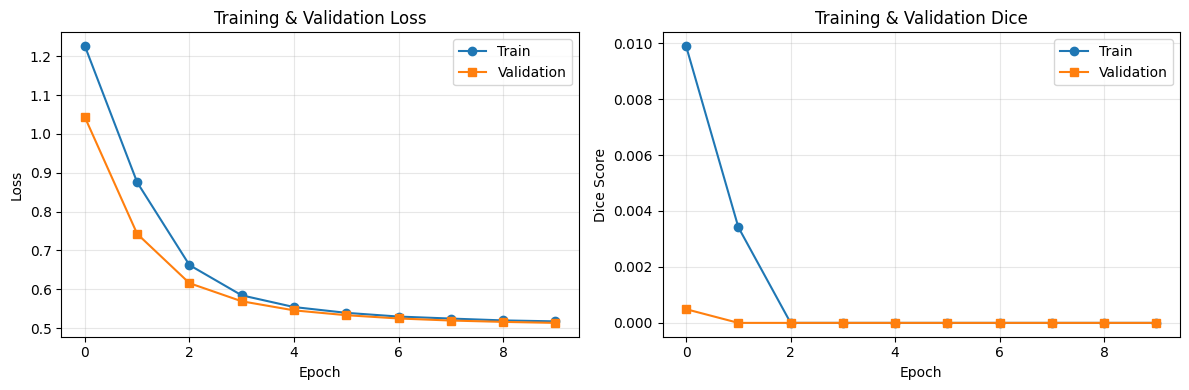

In [14]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history["train_loss"], marker="o", label="Train")
axes[0].plot(history["val_loss"], marker="s", label="Validation")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dice Score
axes[1].plot(history["train_dice"], marker="o", label="Train")
axes[1].plot(history["val_dice"], marker="s", label="Validation")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Dice Score")
axes[1].set_title("Training & Validation Dice")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Final metrics
print("=" * 40)
print("Final Results")
print("=" * 40)
print(f"Best Train Dice: {max(history['train_dice']):.4f}")
print(f"Best Val Dice: {max(history['val_dice']):.4f}")
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")

Final Results
Best Train Dice: 0.0099
Best Val Dice: 0.0005
Final Train Loss: 0.5172
Final Val Loss: 0.5133


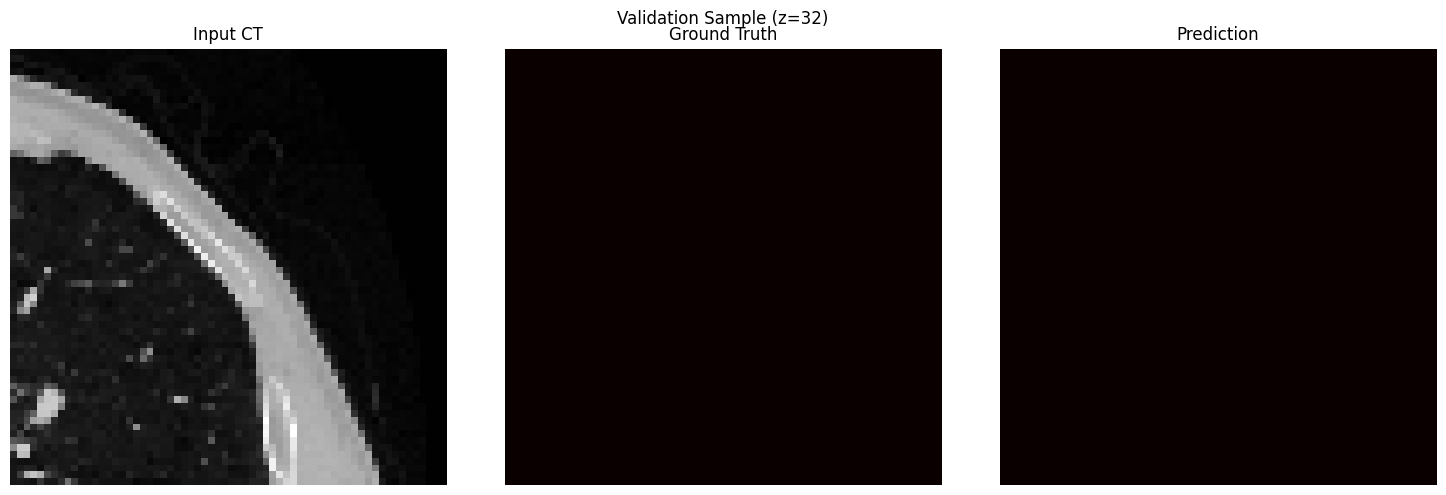

In [16]:
# Visualize predictions on validation data
model.eval()
batch = next(iter(val_loader))
images = batch["image"][:, 0:1, ...].to(DEVICE)
labels = batch["image"][:, 1:2, ...].cpu().numpy()

with torch.no_grad():
    images_norm = normalize_ct(images)
    outputs = model(images_norm)
    preds = torch.argmax(outputs, dim=1, keepdim=True).cpu().numpy()

# Show first sample
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
mid_z = images.shape[4] // 2

# CT
axes[0].imshow(images[0, 0, :, :, mid_z].cpu().T, cmap="gray", origin="lower")
axes[0].set_title("Input CT")
axes[0].axis("off")

# Ground Truth
axes[1].imshow(labels[0, 0, :, :, mid_z].T, cmap="hot", origin="lower")
axes[1].set_title("Ground Truth")
axes[1].axis("off")

# Prediction
axes[2].imshow(preds[0, 0, :, :, mid_z].T, cmap="hot", origin="lower")
axes[2].set_title("Prediction")
axes[2].axis("off")

plt.suptitle(f"Validation Sample (z={mid_z})")
plt.tight_layout()
plt.show()

In [17]:
# Cleanup temporary directory
shutil.rmtree(TEMP_DIR)
print(f"Cleaned up: {TEMP_DIR}")

Cleaned up: /var/folders/dj/0_0s64j55hn0gk7rrvj09zf80000gn/T/msd_ml_l6x_amwt
